2 Model evaluation
-------------------

As you notice, train and fit a model to a dataset is not intuitive as it seems to be. You need to make quite many decisions to choose and train your model. Especially according to the *short exercise 0.0* in *section 0*, when different sets of observations are made, you could have a different model trained by the new observations. ***How do you know or evaluate model performance with so many choices?*** Then you might want to find a way to verify your choices regarding model complexity and **regularization**.

In fact, people are always seeking ways to **validate** their model by using new datasets. However, you are not alway lucky to have many datasets in real world situation. But you can do a trick to pretend like having multiple datasets. For instance, you can split what you have at hand into **training** and **validation** sets, based upon which you can verify the performance of your *trained* model on another dataset. **Validation** is very useful for choosing model complexity, such as the number of polynomial terms in our previous example, or for deciding the extent of **regularization**. In the following experiment, you will be leveraging **validation** to find a proper **number of polynomial terms**, and also examine the **regularization** parameter for the *Sklearn Ridge* and *Lasso*.

### 2.0 Validation and parameter tuning

You will again use dummy dataset generated from our sinusoid model. This time you will have 20 data points generated in total. As been said above, this data set will be splitted into **training** and **validation** so that the **regularization** parameter can be tested. Normally, you would like to use 70% of your data for **training** and the rest of the 30% for **validation**.

Recall how you generated the dummy dataset.

In [1]:
import numpy as np  # You will be using Numpy module
import matplotlib.pyplot as plt  # Module for visualization will also be used

# Define the true function for generating dummy dataset
def func(x):
    # Generate sample dataset from a linearly transformed sinusoidal function: y=sin(x)+0.3*x+e (where 'e' is random noise)
    return np.sin(x) + .3*x

# Define function for generating dummy dataset
def dummyData(func, sample_size, std):
    # Artificially generate input x
    x = np.random.rand(sample_size)[:,None]; x=x*15-5
    # Call function to generate response y
    y = func(x) + np.random.normal(scale=std, size=x.shape)
    return x, y

Text(0.5, 1.0, 'Data fitted: two models')

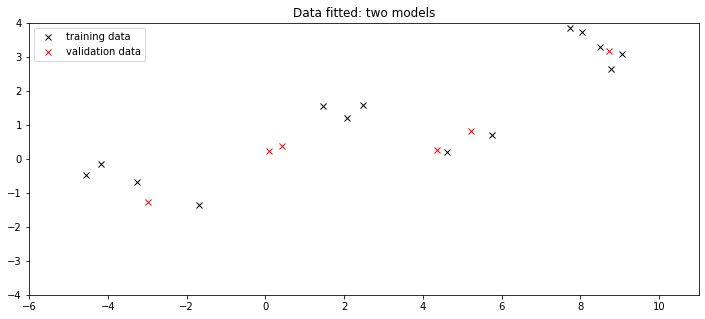

In [14]:
# First, you need a function to split your dataset into 'training' and 'validation' sets.
def trainValSplit(x, y):
    x_train = x[:int(0.7*len(x))]  # 70% of data for training
    x_val = x[int(0.7*len(x)):]  # 30% for testing
    y_train = y[:int(0.7*len(y))]  # 70% of data for training
    y_val = y[int(0.7*len(y)):]  # 30% for testing
    return x_train, y_train, x_val, y_val

# Then, you need a function to evaluate the model performance by measuring difference between data and prediction
def rmse(a, b):
    return np.sqrt(np.mean(np.square(a - b)))

# Let's use the 8th order polynomial again.
deg = 8
# Prepare training and validation
x, y = dummyData(func, 20, 0.25)  # Generate 20 dummy data points by using function defined in section 0.0
x_train, y_train, x_val, y_val = trainValSplit(x, y)

plt.figure(figsize=(12,5))
plt.xlim([-6., 11])
plt.ylim([-4, 4])
plt.plot(x_train,y_train,'kx',label='training data')
plt.plot(x_val,y_val,'rx',label='validation data')
plt.legend()
plt.title('Data fitted: two models')


### 2.1 Model complexity inspection

What do you see in the training and validation error/RMSE? When polynomial terms are increasing, the model is more flexible to capture all the information in the training set, but complex model does NOT generalized to other dataset as it **overfits** the training data! The consequence is that the RMSE for the training set continues to decrease but the RMSE for the test set remains much higher.

Recall how you defined function to fit/train your model.

In [15]:
import functools
import itertools

# Define a function to fit a linear model to the dummy data.
def fit(x, y):
    # x : (N, D) np.ndarray
    # y : (N,) np.ndarray
    # Linear fit means a linear model in the form of M(x) = θ1 + θ2x is assumed
    # Or, in the form of matrix multiplication M(X) = θ'X, where
    # X is referred as designed vector/matrix in the form of [1, x]' and θ is [θ1, θ2]'
    X_mat=np.hstack((np.ones(len(x)).reshape(-1,1), x))  # X_mat is a designed matrix
    
    # Given the observed data y, a proper solution of θ to M(x) can be: θ* = argmin (||y - X @ θ||^2_2)
    theta = np.linalg.inv(X_mat.T.dot(X_mat)).dot(X_mat.T).dot(y)  # If you see an @ in the middle of a line, that's matrix multiplication.
    var = np.mean(np.square(X_mat @ theta - y))
    return theta, var

def predict(x, theta, var, return_std:bool=False):
    X_mat=np.hstack((np.ones(len(x)).reshape(-1,1), x))  # X_mat is a designed matrix
    y = X_mat @ theta
    if return_std:
        y_std = np.sqrt(var) + np.zeros_like(y)
        return y, y_std
    return y

# Define a fuction that project inputs into higher order polynomial inputs. 
# For instance, when degree=3, x becomes to (x, x^2, x^3).
def transform(x, degree):
    # Transforms input array with polynomial features
    # x : (sample_size, n) ndarray
    # Output : (sample_size, 1 + nC1 + ... + nCd) ndarray

    if x.ndim == 1:
        x = x[:, None]
    x_t = x.transpose()
    features = []
    for degree in range(1, degree + 1):
        for items in itertools.combinations_with_replacement(x_t, degree):
            features.append(functools.reduce(lambda x, y: x * y, items))
    return np.asarray(features).transpose()

Text(0, 0.5, 'RMSE')

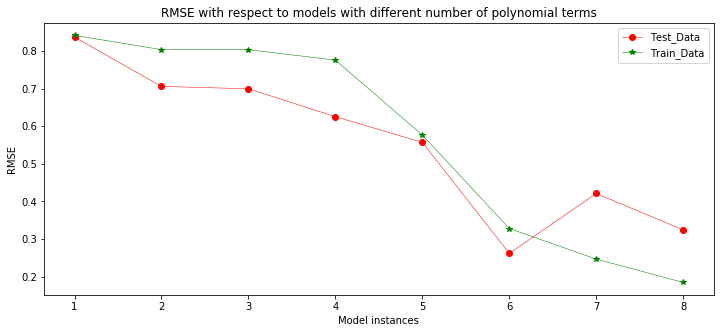

In [16]:
# Now, you can examine models with different number of polynomial terms
RMSE_val = []
RMSE_train = []

# Number of polynomial terms from 1 to 8
for i in range(1, 9):
    deg = i  # Changing degree of polynomial function
    weights, variance = fit(transform(x_train, deg), y_train)  # Fit data using function defined in section 0.1
    
    # Record RMSE for training and validation sets
    RMSE_train.append(rmse(predict(transform(x_train, deg), weights, variance), y_train))
    RMSE_val.append(rmse(predict(transform(x_val, deg), weights, variance), y_val))

# Plot model performance with different regularization parameter
plt.figure(figsize=(12,5))
plt.plot(range(1,len(RMSE_val)+1), RMSE_val,'-or', linewidth=.5, label='Test_Data')
plt.plot(range(1,len(RMSE_train)+1), RMSE_train, '-*g', linewidth=.5, label='Train_Data')
plt.legend()
plt.title('RMSE with respect to models with different number of polynomial terms')
plt.xlabel('Model instances')
plt.ylabel('RMSE')

### 2.2 Regularizer inspection

Now, you can test different 'Ridge' or 'Lasso' parameters.

In the above examples, you used an user defined 'ridge regression' function, but 'sklearn' also provided a predefined one.

Text(0, 0.5, 'RMSE')

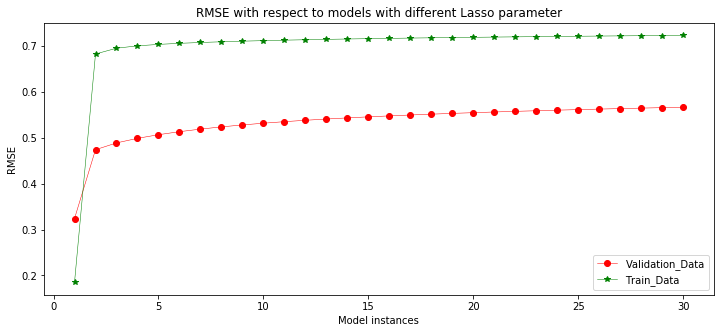

In [17]:
# You will be using the 'Ridge' and 'Lasso' functions all from the 'sklearn' module.
from sklearn.linear_model import Ridge, Lasso

RMSE_val = []
RMSE_train = []
for i in range(1, 300000, 10000):
    model = Ridge(alpha=i/100)  # Configure model with different regularization parameter
    # Then, fit this model to the data.
    model.fit(transform(x_train, deg), y_train)
    
    RMSE_train.append(rmse(model.predict(transform(x_train, deg)), y_train))
    RMSE_val.append(rmse(model.predict(transform(x_val, deg)), y_val))

# Plot model performance with different regularization parameter
plt.figure(figsize=(12,5))
plt.plot(range(1,len(RMSE_val)+1), RMSE_val,'-or', linewidth=.5, label='Validation_Data')
plt.plot(range(1,len(RMSE_train)+1), RMSE_train, '-*g', linewidth=.5, label='Train_Data')
plt.legend()
plt.title('RMSE with respect to models with different Lasso parameter')
plt.xlabel('Model instances')
plt.ylabel('RMSE')

### Short exercise 2.0

What do see in the figure? Does the figure looks the same if you **re-run** the above codes for multiple times?

Please try to inspect the performance of *Lasso* regularizer the same way shown above. What do you see again?

In [ ]:
#==================================
# Answers and hints 0.1
#==================================

# Different from model complexity inspection, when you run the code above for regularizer inspection, the RMSE curves for both
# training and validation data are not stable as shown in model complexity inspection. It means that the Ridge regularizer does
# not bring same regularization effect everytime. Why? Because the polynomial term (x1, x2, x3,...,x8) are highly correlated.
# Since they are only transformed from the original input x, they are very similar! Thus it is difficult for the regularizer 
# to decide which term should be eliminated and which should be retained, resulting in different versions of regularized model.
# But still, there are general trends, for instance, when the model is significantly regularized, the RMSE for both training
# and validation data are similarly high.

# Preferably, when you deploy linear regression with multiple variables or features, you need to check the collinearity among
# the variables before the regression.